# CS4248 Project - Labelled Unreliable News (LUN)

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [11]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stemmer = None
# lemmatizer = None

TEST_SIZE = 0.1

## Helper Functions

In [12]:
def preprocess(sentence, lower_case=True, remove_punctuation=True, replace_contractions=True):
    if lower_case:
        sentence = sentence.lower()
    if remove_punctuation:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    if replace_contractions:
        news = sentence.split()
        new_news = []
        for word in news:
            if word in contractions:
                new_news.append(contractions[word])
            else:
                new_news.append(word)
        sentence = " ".join(new_news)
    return sentence

In [13]:
def tokenize(sentence, stemmer=stemmer, lemmatizer=lemmatizer, remove_stop_words=False):
    tokens = word_tokenize(sentence)
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    if lemmatizer:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens

## Load Data

In [14]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [15]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

sample_df = train_df.groupby('label').apply(lambda x: x.sample(frac=0.25))
print(f"No. training samples (sampled classes): {len(sample_df)}")


No. training samples (all classes): 48652
No. training samples (sampled classes): 12164


## Preprocessing

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

encoder = OneHotEncoder(sparse=False)

X = sample_df['text'].values
y = encoder.fit_transform(sample_df[['label']])
print("Before:", X[0])

Before: Noting that its incoming class of high school freshmen is their most coddled to date, instructors at Chestnut Ridge Academy for the Arts told an education conference this week that its mission is to take bright, precocious boys and girls and transform them into insufferable young adults. Here at Chestnut Ridge, we are dedicated to providing artistically gifted young people with the resources they need to blossom into entitled, condescending men and women with an inflated sense of self-importance and accomplishment, Principal Madeleine Healey told conference attendees, noting that the school has already graduated thousands of budding young narcissists with zero sense of shame or perspective. Of course, many of our students are already immensely smug and self-satisfied when they arrive. But after years of only talking about themselves and receiving undeserved praise from everyone around them, theyll leave our doors more pompous and unbearable than we ever thought possible. Healey

In [58]:
# Check labels assigned to categories
display(sample_df.head())
print(y[0], y[-1])
encoder.categories_

label                                               text
label                                                                
1     11269      1  Noting that its incoming class of high school ...
      10561      1  Asserting that the workplace had to have multi...
      11710      1  EVANSVILLE, WYRod Jensen, a 25-year-old smoker...
      3675       1  Gregg Reinisch, a Clarksville-area masturbator...
      7816       1  A local monkfish bemoaned the culinary trendin...

[1. 0. 0. 0.] [0. 0. 0. 1.]


[array([1, 2, 3, 4])]

In [56]:
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser


def summarize_text(text, num_sentences):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = Summarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join([str(sentence) for sentence in summary])
    
# parser = PlaintextParser.from_string(X[0], Tokenizer("english"))
# summarizer = Summarizer()
# num_sentences = 3
# summary = summarizer(parser.document, num_sentences)

# for sentence in summary:
#     print(sentence)

print("After:", summarize_text(X[0], 3))
X = [summarize_text(text, 3) for text in X]

After: Noting that its incoming class of high school freshmen is their most coddled to date, instructors at Chestnut Ridge Academy for the Arts told an education conference this week that its mission is to take bright, precocious boys and girls and transform them into insufferable young adults. Here at Chestnut Ridge, we are dedicated to providing artistically gifted young people with the resources they need to blossom into entitled, condescending men and women with an inflated sense of self-importance and accomplishment, Principal Madeleine Healey told conference attendees, noting that the school has already graduated thousands of budding young narcissists with zero sense of shame or perspective. But after years of only talking about themselves and receiving undeserved praise from everyone around them, theyll leave our doors more pompous and unbearable than we ever thought possible.


In [57]:
X = [preprocess(sentence) for sentence in X]
X = [tokenize(sentence) for sentence in X]
print("After:", X[0])

After: ['noting', 'that', 'it', 'incoming', 'class', 'of', 'high', 'school', 'freshman', 'is', 'their', 'most', 'coddled', 'to', 'date', 'instructor', 'at', 'chestnut', 'ridge', 'academy', 'for', 'the', 'art', 'told', 'an', 'education', 'conference', 'this', 'week', 'that', 'it', 'mission', 'is', 'to', 'take', 'bright', 'precocious', 'boy', 'and', 'girl', 'and', 'transform', 'them', 'into', 'insufferable', 'young', 'adult', 'here', 'at', 'chestnut', 'ridge', 'we', 'are', 'dedicated', 'to', 'providing', 'artistically', 'gifted', 'young', 'people', 'with', 'the', 'resource', 'they', 'need', 'to', 'blossom', 'into', 'entitled', 'condescending', 'men', 'and', 'woman', 'with', 'an', 'inflated', 'sense', 'of', 'selfimportance', 'and', 'accomplishment', 'principal', 'madeleine', 'healey', 'told', 'conference', 'attendee', 'noting', 'that', 'the', 'school', 'ha', 'already', 'graduated', 'thousand', 'of', 'budding', 'young', 'narcissist', 'with', 'zero', 'sense', 'of', 'shame', 'or', 'perspecti

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
len(X_train), len(X_test)

(10947, 1217)

In [60]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")    # num_words: the maximum number of words to keep, based on word frequency. 
                                                            # Only the most common num_words-1 words will be kept. If none, no limit is set.

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)    # Transforms each text in texts to a sequence of integers.
X_test = tokenizer.texts_to_sequences(X_test)

In [61]:
from tensorflow.keras.utils import pad_sequences

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print("Vocab size:", vocab_size, '\n')            # To be used in Embedding layer

def calculate_max_sentence_length(sentences):
    word_count = lambda sentence: len(sentence)
    longest_sentence = max(X_train, key=word_count)
    maxlen = len(longest_sentence) + 10
    print(longest_sentence, '\n')
    print(maxlen)
    return maxlen

# maxlen = 256
maxlen = calculate_max_sentence_length(X_train) + 16
print(f'Max sentence length: {maxlen}')

X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=maxlen)
len(X_train), len(X_train[0])

Vocab size: 47839 

[2464, 4610, 10, 45, 12, 2, 89, 1252, 5, 2, 998, 1689, 63, 35, 456, 22, 4, 2548, 4, 640, 602, 528, 1500, 5, 2, 1356, 998, 3968, 40825, 640, 602, 506, 2464, 771, 1056, 787, 747, 3436, 2898, 582, 89, 1751, 1552, 9, 3369, 5, 3391, 2016, 13144, 40826, 2587, 640, 602, 506, 2464, 771, 1217, 787, 2045, 3681, 26, 2842, 12, 1118, 4, 3, 8345, 5, 10814, 23, 399, 319, 6, 16, 190, 2587, 640, 602, 506, 2464, 771, 1217, 787, 2045, 3681, 7752, 117, 319, 12, 1118, 13, 10012, 8875, 6, 11024, 7334, 12, 2, 3156, 2587, 640, 602, 506, 2464, 771, 1217, 787, 3556, 189, 510, 168, 12159, 29, 3498, 6921, 291, 101, 410, 4, 2030, 210, 41, 1552, 2587, 640, 602, 506, 2464, 771, 1217, 787, 321, 3884, 1360, 5847, 197, 412, 12265, 21, 2045, 22103, 7228, 10395, 2587, 640, 602, 506, 2464, 771, 1217, 787, 1360, 5847, 538, 91, 211, 90, 7, 107, 1393, 510, 4605, 2587, 640, 602, 506, 2464, 771, 1217, 787, 119, 56, 6438, 3312, 22104, 50, 9759, 927, 147, 81, 10919, 1692, 3681, 2587, 640, 602, 506, 2464, 771,

(10947, 789)

In [62]:
glove_dir = 'raw_data/glove.840B.300d.txt'
embeddings_index = {}

with open(glove_dir, encoding='utf-8') as f:
    for line in f:
        # values = line.split()
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 2196007 word vectors.


In [63]:
# Number of dimensions is 300 in glove.840B.300d.txt
print(len(embeddings_index['the']))
print(len(embeddings_index['happy']))

300
300


In [64]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [65]:
# embedding_dim = 50

# def create_embedding_matrix(filepath, word_index, embedding_dim):
#     vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
#     embedding_matrix = np.zeros((vocab_size, embedding_dim))

#     with open(filepath, encoding='utf-8') as f:
#         for line in f:
#             word, *vector = line.split()
#             if word in word_index:
#                 idx = word_index[word] 
#                 embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

#     return embedding_matrix

# embedding_matrix = create_embedding_matrix(
#     'raw_data/glove.840B.300d.txt',
#     tokenizer.word_index, embedding_dim)

In [66]:
print(y_test.shape)
print(X_test.shape)
print(y_train.shape)
print(X_train.shape)

(1217, 4)
(1217, 789)
(10947, 4)
(10947, 789)


## Training

In [67]:
from keras.models import Sequential
from keras import layers 

model = Sequential()
input_dim = X_train.shape[1]
num_cats = 4

def build_embconvmax_model():
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(num_cats, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

def build_embpre_model0():
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.Dropout(0.2))    
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dropout(0.4))    
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()

def build_embpre_model():
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.Dropout(0.5))    
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dropout(0.5))    
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(num_cats, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-05 13:09:21.049504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 13:09:21.051421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [68]:
# Define Callbacks
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = EarlyStopping(monitor='val_loss', 
                        min_delta=1e-3, 
                        patience=5, 
                        verbose=1, 
                        mode='auto',
                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [69]:
def train_model(X_train, Y_train, X_test, Y_test):
    return model.fit(
        X_train,
        Y_train,
        epochs=256,
        validation_data=(X_test, Y_test),
        batch_size=16,
        callbacks=[monitor, reduce_lr],
    )

In [70]:
def evaluate_model(X_train, Y_train, X_test, Y_test):
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Loss: {:.4f}".format(loss))
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Loss:  {:.4f}".format(loss))
    print("Testing Accuracy:  {:.4f}".format(accuracy))

In [71]:
# Helper function to visualize the loss and accuracy for the training and testing data based on the History callback. 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [72]:
build_embpre_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 789, 300)          14351700  
                                                                 
 conv1d (Conv1D)             (None, 787, 128)          115328    
                                                                 
 dropout (Dropout)           (None, 787, 128)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                        

In [73]:
history = train_model(X_train, y_train, X_test, y_test)


Epoch 1/256


2023-04-05 13:09:22.724314: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 13:09:23.172068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


685/685 [==============================] - ETA: 0s - loss: 0.9027 - accuracy: 0.6313

2023-04-05 13:10:38.574789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


685/685 [==============================] - 78s 108ms/step - loss: 0.9027 - accuracy: 0.6313 - val_loss: 0.7064 - val_accuracy: 0.7921 - lr: 0.0010
Epoch 2/256
685/685 [==============================] - 75s 110ms/step - loss: 0.4757 - accuracy: 0.8242 - val_loss: 0.5195 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 3/256
685/685 [==============================] - 73s 107ms/step - loss: 0.2964 - accuracy: 0.8945 - val_loss: 0.4773 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 4/256
685/685 [==============================] - 73s 106ms/step - loss: 0.1827 - accuracy: 0.9362 - val_loss: 0.4241 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 5/256
685/685 [==============================] - 72s 105ms/step - loss: 0.1030 - accuracy: 0.9649 - val_loss: 0.4398 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 6/256
685/685 [==============================] - 69s 101ms/step - loss: 0.0680 - accuracy: 0.9762 - val_loss: 0.4382 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 7/256
685/685 [==============================] - 67s

Training Loss: 0.1326
Training Accuracy: 0.9855
Testing Loss:  0.4241
Testing Accuracy:  0.8496


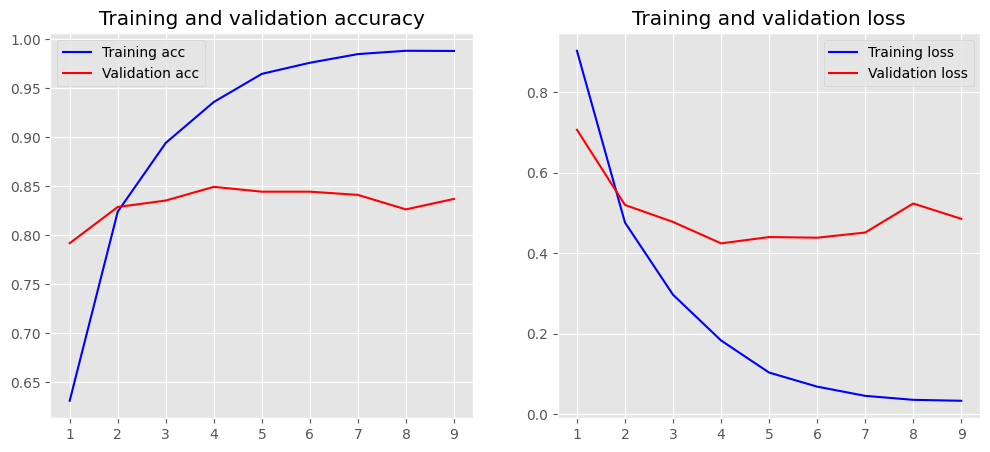

In [74]:
evaluate_model(X_train, y_train, X_test, y_test)
plot_history(history)

## Validation

In [75]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
759,2,"Michele Bachmann - Johnson, Obama Want To Stea..."
974,2,State Department Had No Inspector General Duri...
2190,3,Tweet (NewsTarget) Osteoporosis is a conditio...
2066,3,Oxidative stress is a constant force in our e...
771,2,Greatest Dad Wins Ever! You Wont Believe this ...


In [76]:
X_val = test_df['text'].values
y_val = test_df['label'].values

# Do the same preprocessing steps as training data: preprocess, tokenize, pad sequences
X_val = [preprocess(sentence) for sentence in X_val]
X_val = [tokenize(sentence) for sentence in X_val]
print("After:", X_val[0])


After: ['when', 'so', 'many', 'actor', 'seem', 'content', 'to', 'churn', 'out', 'performance', 'for', 'a', 'quick', 'paycheck', 'a', 'performer', 'who', 'adheres', 'to', 'his', 'principle', 'really', 'stand', 'out', 'thats', 'why', 'jeff', 'bridge', 'made', 'wave', 'this', 'week', 'when', 'he', 'announced', 'that', 'from', 'now', 'on', 'he', 'will', 'only', 'perform', 'nude', 'scene', 'in', 'an', 'interview', 'in', 'this', 'month', 'gq', 'the', 'big', 'lebowski', 'star', 'made', 'it', 'clear', 'that', 'he', 'wa', 'more', 'than', 'ready', 'to', 'move', 'on', 'to', 'a', 'new', 'phase', 'in', 'his', 'career', 'leaving', 'his', 'clothed', 'role', 'in', 'the', 'past', 'ive', 'been', 'there', 'and', 'ive', 'done', 'that', 'said', 'bridge', 'rattling', 'off', 'a', 'laundry', 'list', 'of', 'the', 'film', 'he', 'appeared', 'in', 'covered', 'up', 'now', 'i', 'can', 'finally', 'afford', 'to', 'only', 'take', 'on', 'role', 'that', 'excite', 'me', 'right', 'now', 'those', 'are', 'role', 'with', 'nu

In [77]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
len(X_val[0])

789

In [78]:
y_pred = model.predict(X_val)
predicted_indexes = np.argmax(y_pred, axis=1)
y_pred_val = [pred_class + 1 for pred_class in predicted_indexes]
y_pred_val

2023-04-05 13:20:10.329734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 2s 13ms/step


[1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 4,
 1,
 4,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 4,
 3,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,


In [79]:
# y_pred_val = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.5513333333333333
F1 score: 0.5286294512345218


In [80]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.45      0.84      0.59       750
        hoax       0.79      0.21      0.33       750
  propaganda       0.53      0.52      0.53       750
    reliable       0.71      0.64      0.67       750

    accuracy                           0.55      3000
   macro avg       0.62      0.55      0.53      3000
weighted avg       0.62      0.55      0.53      3000



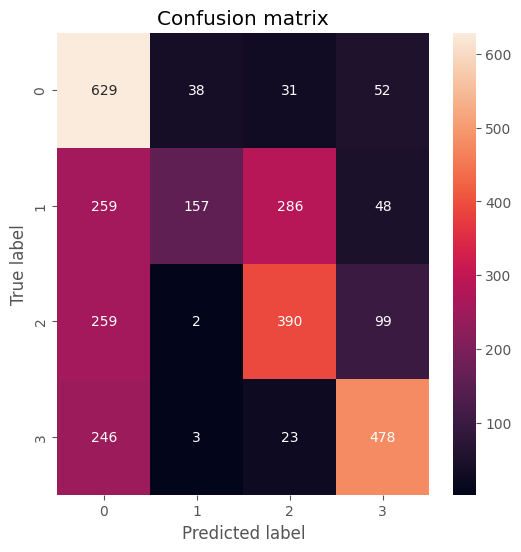

In [81]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	